## Testing the OptMRL model on the 25to100 MRL dataset

1) Determine what proportion of the mrl50 sequences are also in mrl25to100
2) Keep those sequences of mrl25to100 that are not in mrl50
3) Correlate MRL values from aligned sequence as sanity check for matching and test the upper prediction bound 
3) Test OptMRL and O5P on the remaining dataset

In [1]:
import pandas as pd
import numpy as np
from Bio import Align
import matplotlib.pyplot as plt
import scipy as sp
import timeit
import pickle

import sys
sys.path.insert(0,'/fast/AG_Ohler/frederick/projects/mlcis/utils')

from sklearn import preprocessing
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers import BatchNormalization


seed = 42
np.random.seed(seed)

In [2]:
def r2(x,y):
    res = sp.stats.linregress(x, y)
    return round(res.rvalue**2, 4)

def r(x,y):
    res = sp.stats.linregress(x, y)
    return round(res.rvalue, 4)

#from https://gist.github.com/slowkow/06c6dba9180d013dfd82bec217d22eb5
def nw(x, y, match = 1, mismatch = 1, gap = 1):
    nx = len(x)
    ny = len(y)
    # Optimal score at each possible pair of characters.
    F = np.zeros((nx + 1, ny + 1))
    F[:,0] = np.linspace(0, -nx * gap, nx + 1)
    F[0,:] = np.linspace(0, -ny * gap, ny + 1)
    # Pointers to trace through an optimal aligment.
    P = np.zeros((nx + 1, ny + 1))
    P[:,0] = 3
    P[0,:] = 4
    # Temporary scores.
    t = np.zeros(3)
    for i in range(nx):
        for j in range(ny):
            if x[i] == y[j]:
                t[0] = F[i,j] + match
            else:
                t[0] = F[i,j] - mismatch
            t[1] = F[i,j+1] - gap
            t[2] = F[i+1,j] - gap
            tmax = np.max(t)
            F[i+1,j+1] = tmax
            if t[0] == tmax:
                P[i+1,j+1] += 2
            if t[1] == tmax:
                P[i+1,j+1] += 3
            if t[2] == tmax:
                P[i+1,j+1] += 4
    # Trace through an optimal alignment.
    i = nx
    j = ny
    rx = []
    ry = []
    while i > 0 or j > 0:
        if P[i,j] in [2, 5, 6, 9]:
            rx.append(x[i-1])
            ry.append(y[j-1])
            i -= 1
            j -= 1
        elif P[i,j] in [3, 5, 7, 9]:
            rx.append(x[i-1])
            ry.append('-')
            i -= 1
        elif P[i,j] in [4, 6, 7, 9]:
            rx.append('-')
            ry.append(y[j-1])
            j -= 1
    # Reverse the strings.
    rx = ''.join(rx)[::-1]
    ry = ''.join(ry)[::-1]
    return '\n'.join([rx, ry])

In [3]:
mrl25to100 = pd.read_csv('GSM4084997_varying_length_25to100.csv').drop('Unnamed: 0', axis=1)
mrl25to100 = mrl25to100.loc[mrl25to100.set == 'human']
mrl25to100 = mrl25to100.loc[mrl25to100.total_reads >= 10 ]  #select reporters with most reads similar to Sample et. al
mrl25to100 = mrl25to100.sort_values('total', ascending = False).reset_index(drop = True)

mrl50 = pd.read_csv('GSM3130443_designed_library.csv').drop('Unnamed: 0', axis=1)
mrl50 = mrl50[(mrl50['library'] == 'human_utrs') | (mrl50['library'] == 'snv')]
mrl50 = mrl50.sort_values('total', ascending = False).reset_index(drop = True).iloc[:25000] #select reporters with most reads

/tmp/ipykernel_237099/2720430061.py:6: DtypeWarning: Columns (33,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  mrl50 = pd.read_csv('GSM3130443_designed_library.csv').drop('Unnamed: 0', axis=1)


In [4]:
aligner = Align.PairwiseAligner()
print(aligner.algorithm)
aligner.open_gap_score = -1
aligner.extend_gap_score = 0

Needleman-Wunsch


How many of these sequences are also in the MRL-50nt dataset and would therefore not be suitable to test the OptMRL model with?

In [5]:
%timeit
score_dict = {}
tup_list = []
rl50 = mrl50['utr'].values.tolist()
print(len(rl50))
rl100 = mrl25to100['utr'].values.tolist()
print(len(rl100))

print(aligner.algorithm)


for j,seq1 in enumerate(rl50):
    for i,seq2 in enumerate(rl100):
        score = aligner.score(seq1, seq2[-50:])
        if score > 40:
            score_dict[seq1] = seq2
            if i not in [tupleobj[1] for tupleobj in tup_list]:
                tup_list.append((j,i))

25000
15555
Gotoh global alignment algorithm


In [6]:
#this is the number of sequences shared between both datasets
len(score_dict)

#print(nw(mrl50['utr'].iloc[1241], mrl25to100['utr'].iloc[1231]))

6754

In [28]:
#import pickle
#with open('matched_seqs_dict.pkl','wb') as f:
#    pickle.dump(score_dict, f)

#with open('matches_seqs_idx_tup.pkl','wb') as f:
#    pickle.dump(tup_list, f)
    

In [5]:
comb50 = mrl50.rename(columns={'rl':'rl50', 'utr':'utr50'})
comb25to100 = mrl25to100.rename(columns={'rl':'rl25to100', 'utr':'utr25to100'})
comb50 = comb50[['utr50', 'rl50']]
comb25to100 = comb25to100[['utr25to100', 'rl25to100']]

#make new dataframe that contains matched sequences and their mrl values
comb_rows = []
for j, i in tup_list:
    #get rows corresponding to indices
    rowj = comb50.iloc[j]
    rowi = comb25to100.iloc[i]
    #concatenate rows
    rows = pd.concat([rowj, rowi])
    comb_rows.append(rows)
    comb_df = pd.DataFrame(comb_rows)

In [4]:

with open('matches_seqs_idx_tup.pkl','rb') as f:
    tup_list = pickle.load(f)

#idx_list = [tupleobj[1] for tupleobj in tup_list]
#mrl25to100_filtered = mrl25to100.loc[~mrl25to100.index.isin(idx_list)]

#with open('mrl25to100_filtered.pkl','rb') as f:
#    mrl25to100_filtered = pickle.load(f)

### Correlate MRL values of the matched sequence pairs

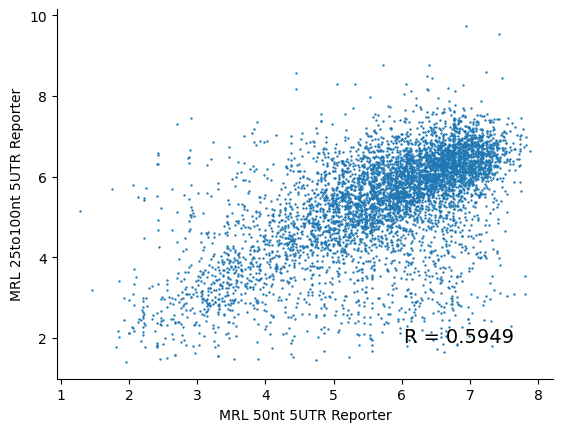

In [13]:
fig, axs = plt.subplots()
axs.scatter(comb_df['rl50'], comb_df['rl25to100'], s=0.5)
axs.annotate('R = %s' % r(comb_df['rl50'],comb_df['rl25to100']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)
axs.set_ylabel('MRL 25to100nt 5UTR Reporter')
axs.set_xlabel('MRL 50nt 5UTR Reporter')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

In [15]:
fig.savefig('/fast/AG_Ohler/frederick/projects/mlcis/data/riboseq/mrl_correlation.pdf')

### Test O5P and OptMRL on the mrl25to100 Dataset

In [9]:
def onehot_var(df, col='five_utr',seq_len=50):
    '''
    takes a column of a param:df specified in param:col and one-hot encodes the dna sequence entries
    into one-hot matrices of equal dimension. Pads to param:seq_len if sequences are shorter than param:seq_len.
    '''
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    vectors=np.empty([len(df),seq_len,4])

    for i,seq in enumerate(df[col].str[:seq_len]): 
        
        seq=seq.lower()
        vec=np.array([nuc_d[x] for x in seq])
        
        while vec.shape[0]<seq_len:
            vec=np.vstack((vec,np.zeros(4)))
    
        vectors[i]=vec

    return vectors



def predict_targets(df, model, name, seq_col='utr', seq_len=50, target='rl', use_scaler=True, which='fit'):
    '''
    takes a param:df with dna sequences, creates a 3d numpy array with a number of one-hot encoded sequences and predicts param:target values (after scaling them) using a param:model.
    then rescales the predicted values obtained from param:model using param:scaler and adds them to the param:df as new param:column.
    '''
    
    #one-hot encode sequences and predict target
    out = model(onehot_var(df, seq_col, seq_len))

    if use_scaler and which == 'fit':
        #use scaler to transform output
        mrl_scaler = preprocessing.StandardScaler()
        mrl_scaler.fit(df['rl'].values.reshape(-1,1))

        #save output in new column
        out_col = 'pred_%s_%s' % (target, name)
        df.loc[:, out_col] = mrl_scaler.inverse_transform(out)

    elif use_scaler and which == 'MRL':
        mrl_df = pd.read_csv('/fast/AG_Ohler/frederick/projects/mlcis/data/human_train.csv', sep=',')
        mrl_scaler = preprocessing.StandardScaler()
        mrl_scaler.fit(mrl_df['rl'].values.reshape(-1,1))

        out_col = 'pred_%s_%s' % (target, name)
        df.loc[:, out_col] = mrl_scaler.inverse_transform(out)

    else:
        out_col = 'pred_%s_%s' % (target, name)
        df.loc[:, out_col] = out
    
def r2(x,y):
    res = sp.stats.linregress(x, y)
    return round(res.rvalue**2, 4)

def r(x,y):
    res = sp.stats.linregress(x, y)
    return round(res.rvalue, 4)

In [10]:
#load data
with open('mrl25to100_filtered.pkl','rb') as f:
    mrl25to100_filtered = pickle.load(f)

utr_len = []
for row in mrl25to100_filtered.utr:
    utr_len.append(len(row))
mrl25to100_filtered['utr_len'] = utr_len

short_utrs_filtered = mrl25to100_filtered[mrl25to100_filtered['utr_len'] <= 50]

long_utrs_filtered = mrl25to100_filtered[mrl25to100_filtered['utr_len'] > 50]

medium_utrs_filtered = mrl25to100_filtered[mrl25to100_filtered['utr_len'] <= 55]
medium_utrs_filtered = medium_utrs_filtered[medium_utrs_filtered['utr_len'] >= 45]

In [11]:


#load models
path = '/fast/AG_Ohler/frederick/projects/mlcis/models'
o5p = keras.models.load_model(path+'/main_MRL_model.hdf5')
omrl = keras.models.load_model(path+'/OptMRL_model.hdf5')

#predict MRL with both models
predict_targets(mrl25to100, o5p,'o5p')
predict_targets(mrl25to100, omrl, 'omrl')

predict_targets(mrl25to100_filtered, o5p,'o5p')
predict_targets(mrl25to100_filtered, omrl, 'omrl')

predict_targets(short_utrs_filtered, o5p,'o5p')
predict_targets(short_utrs_filtered, omrl, 'omrl')

predict_targets(long_utrs_filtered, o5p,'o5p')
predict_targets(long_utrs_filtered, omrl, 'omrl')

predict_targets(medium_utrs_filtered, o5p,'o5p')
predict_targets(medium_utrs_filtered, omrl, 'omrl')

2024-07-04 10:04:35.639308: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_13133/3801875578.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, out_col] = mrl_scaler.inverse_transform(out)
/tmp/ipykernel_13133/3801875578.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Text(0.7, 0.1, 'R = 0.5655')

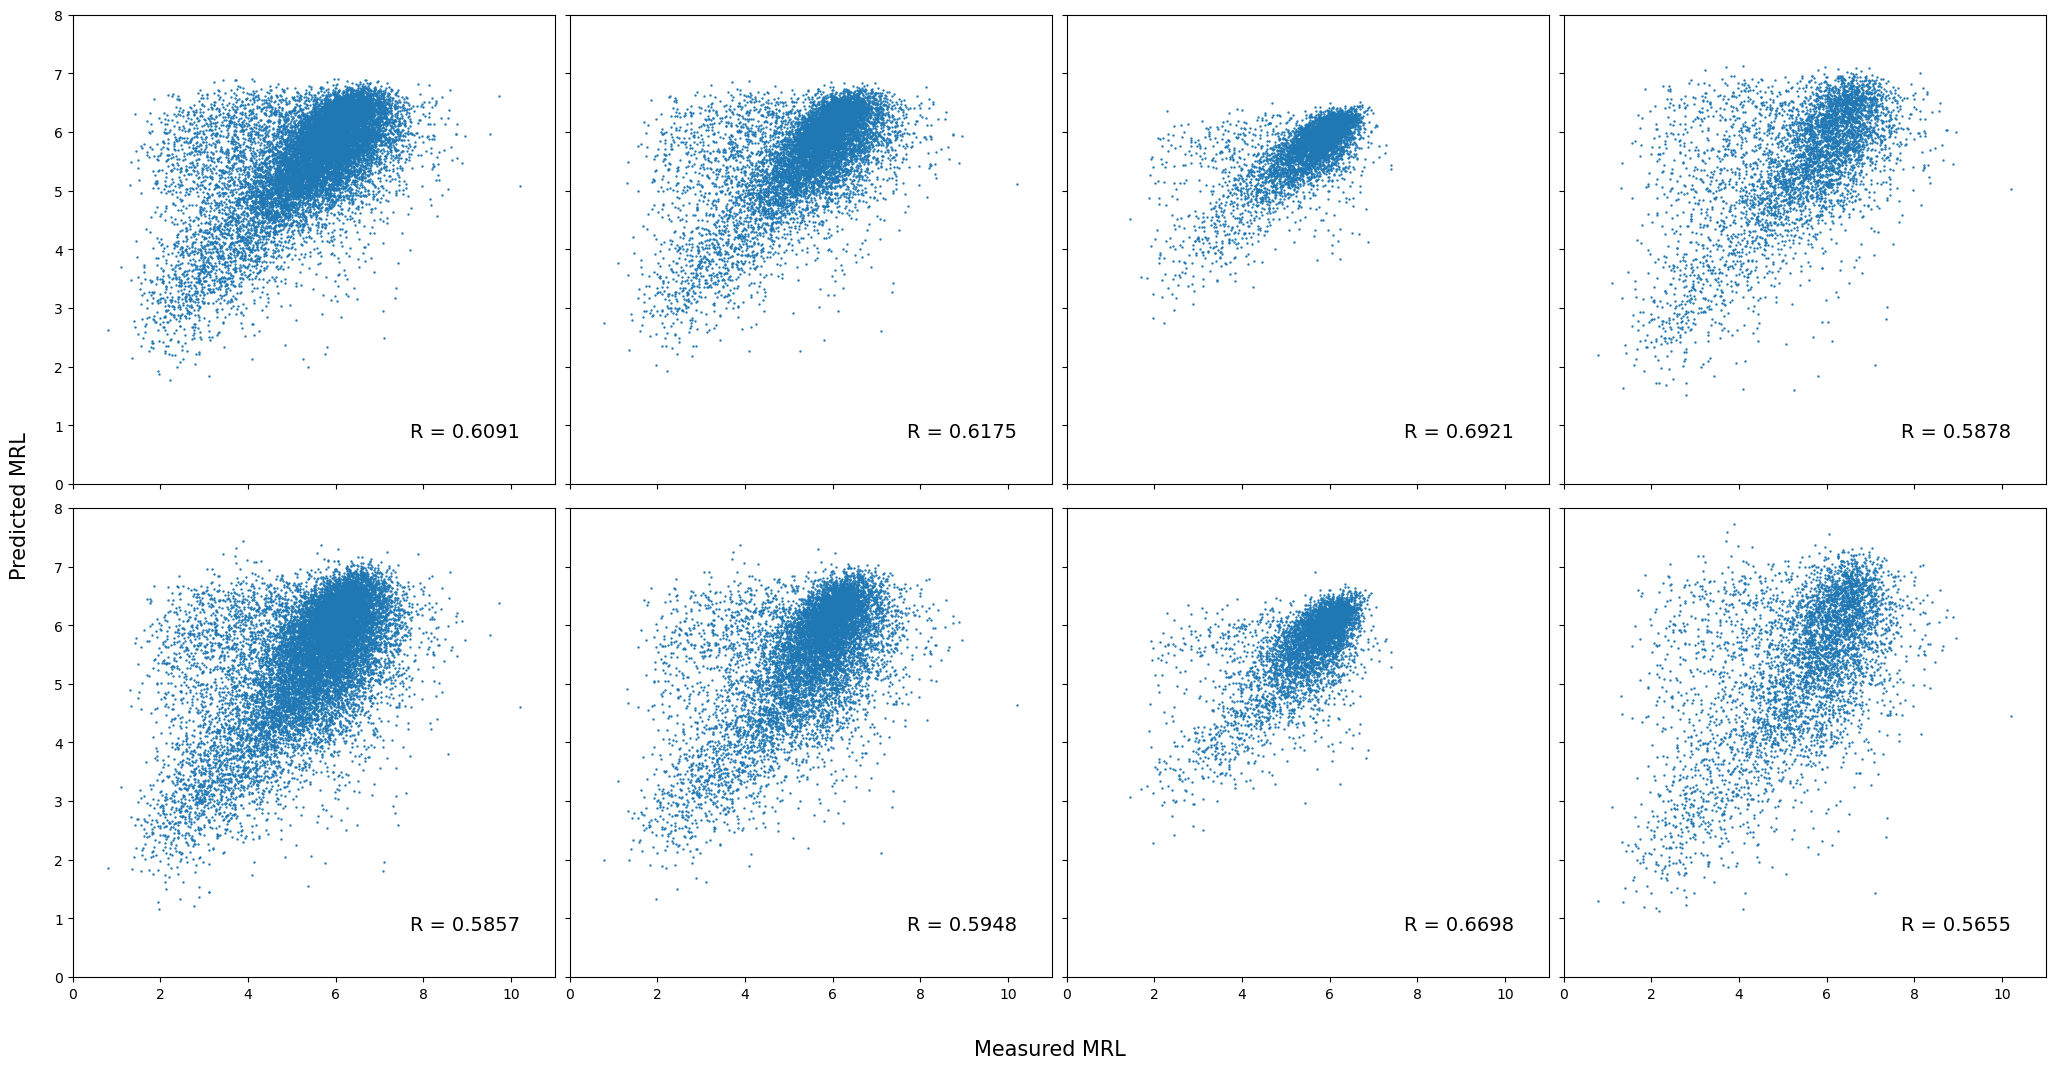

In [12]:
f, ax = plt.subplots(2, 4, sharex=True, sharey=True, layout='constrained', figsize=(20,10))
plt.setp(ax, xlim=(0,11), ylim=(0,8))
f.text(0.5, -0.05, 'Measured MRL', ha='center', fontsize=15)
f.text(-0.02, 0.5, 'Predicted MRL', va='center', rotation='vertical', fontsize=15)

#original mrl25to100
ax[0,0].scatter(mrl25to100['rl'],mrl25to100['pred_rl_o5p'], s=0.5)
ax[0,0].annotate('R = %s' % r(mrl25to100['rl'],mrl25to100['pred_rl_o5p']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)
ax[1,0].scatter(mrl25to100['rl'],mrl25to100['pred_rl_omrl'], s=0.5)
ax[1,0].annotate('R = %s' % r(mrl25to100['rl'],mrl25to100['pred_rl_omrl']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

#mrl25to100 without matches
ax[0,1].scatter(mrl25to100_filtered['rl'],mrl25to100_filtered['pred_rl_o5p'], s=0.5)
ax[0,1].annotate('R = %s' % r(mrl25to100_filtered['rl'],mrl25to100_filtered['pred_rl_o5p']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)
ax[1,1].scatter(mrl25to100_filtered['rl'],mrl25to100_filtered['pred_rl_omrl'], s=0.5)
ax[1,1].annotate('R = %s' % r(mrl25to100_filtered['rl'],mrl25to100_filtered['pred_rl_omrl']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

#sequences shorter than 50 nt in mrl25to100_filtered
ax[0,2].scatter(short_utrs_filtered['rl'],short_utrs_filtered['pred_rl_o5p'], s=0.5)
ax[0,2].annotate('R = %s' % r(short_utrs_filtered['rl'],short_utrs_filtered['pred_rl_o5p']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)
ax[1,2].scatter(short_utrs_filtered['rl'],short_utrs_filtered['pred_rl_omrl'], s=0.5)
ax[1,2].annotate('R = %s' % r(short_utrs_filtered['rl'],short_utrs_filtered['pred_rl_omrl']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

#sequences longer than 50nt in mrl25to100_filtered
ax[0,3].scatter(long_utrs_filtered['rl'],long_utrs_filtered['pred_rl_o5p'], s=0.5)
ax[0,3].annotate('R = %s' % r(long_utrs_filtered['rl'],long_utrs_filtered['pred_rl_o5p']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)
ax[1,3].scatter(long_utrs_filtered['rl'],long_utrs_filtered['pred_rl_omrl'], s=0.5)
ax[1,3].annotate('R = %s' % r(long_utrs_filtered['rl'],long_utrs_filtered['pred_rl_omrl']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)


Text(0.7, 0.1, 'R = 0.6488')

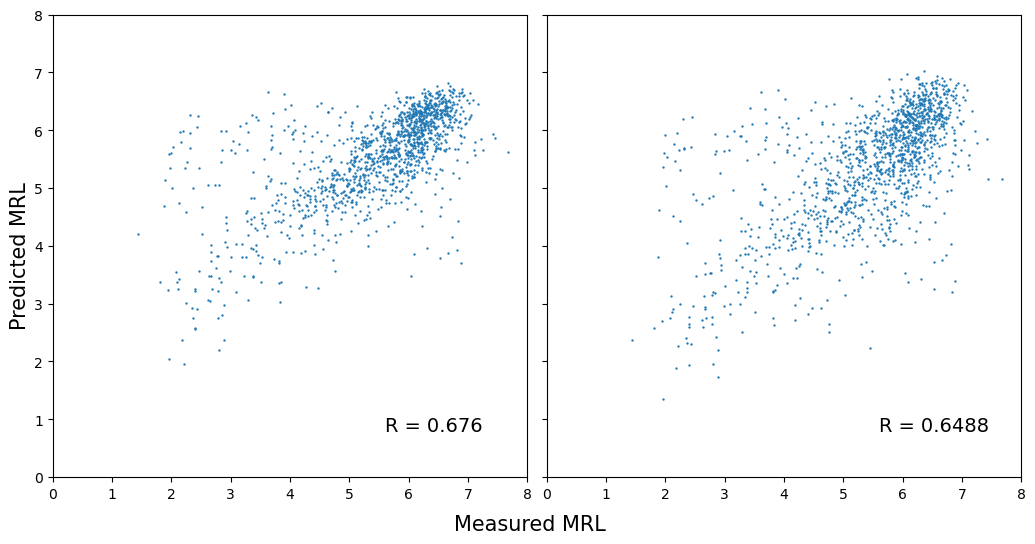

In [13]:
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, layout='constrained', figsize=(10,5))
plt.setp(ax, xlim=(0,8), ylim=(0,8))
f.text(0.5, -0.05, 'Measured MRL', ha='center', fontsize=15)
f.text(-0.02, 0.5, 'Predicted MRL', va='center', rotation='vertical', fontsize=15)

#utrs between 45 and 55 nts in length
ax[0].scatter(medium_utrs_filtered['rl'],medium_utrs_filtered['pred_rl_o5p'], s=0.5)
ax[0].annotate('R = %s' % r(medium_utrs_filtered['rl'],medium_utrs_filtered['pred_rl_o5p']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)
ax[1].scatter(medium_utrs_filtered['rl'],medium_utrs_filtered['pred_rl_omrl'], s=0.5)
ax[1].annotate('R = %s' % r(medium_utrs_filtered['rl'],medium_utrs_filtered['pred_rl_omrl']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

Text(0.7, 0.1, 'R = 0.6698')

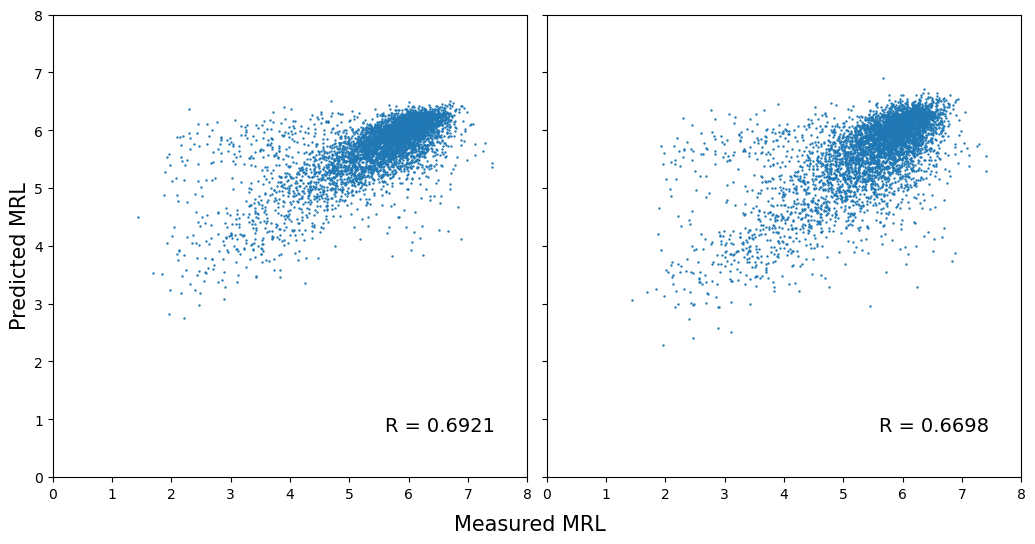

In [14]:
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, layout='constrained', figsize=(10,5))
plt.setp(ax, xlim=(0,8), ylim=(0,8))
f.text(0.5, -0.05, 'Measured MRL', ha='center', fontsize=15)
f.text(-0.02, 0.5, 'Predicted MRL', va='center', rotation='vertical', fontsize=15)

ax[0].scatter(short_utrs_filtered['rl'],short_utrs_filtered['pred_rl_o5p'], s=0.5)
ax[0].annotate('R = %s' % r(short_utrs_filtered['rl'],short_utrs_filtered['pred_rl_o5p']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)
ax[1].scatter(short_utrs_filtered['rl'],short_utrs_filtered['pred_rl_omrl'], s=0.5)
ax[1].annotate('R = %s' % r(short_utrs_filtered['rl'],short_utrs_filtered['pred_rl_omrl']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

#### What do the false positives have in common?

In [67]:
fp = short_utrs_filtered[short_utrs_filtered['rl'] <= 3]
fp = fp[fp['pred_rl_omrl'] >= 5]
fp

,utr,set,0,1,2,3,4,5,6,7,...,r9,r10,r11,r12,total,rl,len,pred_rl_o5p,pred_rl_omrl,utr_len
1,TGGCTCCGAGCTTTGACCTCCGAGAGAGCC,human,507,894,665,319,154,96,44,93,...,0.028872,0.030581,0.028966,0.066409,0.001245,2.842899,30,5.859167,6.196564,30
28,AGGGCAGGATGAACGCTGCTTTCCAAG,human,383,571,373,211,109,66,21,79,...,0.026411,0.030195,0.033836,0.063643,0.000806,2.824708,27,5.762503,5.894861,27
125,TGGCGGCGAACGCGGAGAGCACGCC,human,266,477,375,167,59,55,10,57,...,0.025654,0.029220,0.032644,0.062103,0.000652,2.790705,25,5.680990,5.978830,25
154,CATCTCCAGGCTCCATCTCTTGAACCATGGATCCCAGCGTTGTTAGCA,human,320,555,328,137,49,29,14,26,...,0.024665,0.026596,0.020072,0.052329,0.000622,2.318074,48,5.673479,5.672090,48
184,TGTTTCCTTCGGCTTTCCTCCTCCTGCTCCACC,human,237,452,389,142,68,46,18,46,...,0.031836,0.026347,0.035206,0.040768,0.000604,2.766164,33,6.143752,6.345366,33
235,TCAGCTCCCAGATGGATCCTGGACAGG,human,313,430,247,146,55,40,16,28,...,0.031522,0.026107,0.038677,0.060295,0.000574,2.702694,27,5.629539,5.681826,27
381,AGATGAAGGCTAGGTGGCTGGAACTGCAACC,human,237,380,283,109,64,43,12,31,...,0.030235,0.028911,0.023694,0.062990,0.000507,2.636158,31,5.907384,5.581016,31
456,TCTGCCCACCCATGGATTATCTTGTAAAGAGTCACCTGCCCC,human,305,533,239,51,23,27,8,21,...,0.018844,0.013486,0.020930,0.030165,0.000486,1.921236,42,5.543137,5.735125,42
470,AAACTAAGAGTATGGCTGCAGCAAGCTCCCTCTTGGATTCAGA,human,188,310,268,152,63,41,16,26,...,0.029429,0.018763,0.035945,0.079019,0.000482,2.835857,43,5.829580,5.639875,43
938,TGGCTTTGCTCCTCTTTCTGGGAAGGGGTTGCCCGGCTGTGCTGCCACC,human,199,327,254,74,23,20,10,19,...,0.023082,0.023396,0.022708,0.034106,0.000387,2.319128,49,5.868702,5.653925,49


In [22]:
rl50 = mrl50['utr'].values.tolist()
print(len(rl50))
rl100 = mrl25to100['utr'].values.tolist()
print(len(rl100))

25000
15555


In [23]:
print(nw(rl50[800],rl100[10624]))

---------------------TGAGCGGTGGGGTCTGCGTACGCCTGGAGTCCTTCCCCGCTGTGCTCAGC
TAGTGGCGGGAGGCTGTGAGCTGAGCGGTGGGGTCTGCGTACGCCTGGAGTCCTTCCCCGCTGTGCTCAGC


In [24]:
print(nw(rl50[800],rl100[11023]))

--------------------TGAGCGGTGGGGTCTGCGTACGCCTGGAGTCCTTCCCCGCTGTGCTCAGC
AGTGGCGGGAGGCTGTGAGCTGAGCGGTGGGGTCTGCGTACGCCTGGAGTCCTTCCCCGCTGTGCTCAGC


In [25]:
print(nw(rl50[800],rl100[11579]))

------------------------TGAGCGGTGGGGTCTGCGTACGCCTGGAGTCCTTCCCCGCTGTGCTCAGC
AACTAGTGGCGGGAGGCTGTGAGCTGAGCGGTGGGGTCTGCGTACGCCTGGAGTCCTTCCCCGCTGTGCTCAGC
